# Import Libraries

In [1]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import sklearn
from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score, roc_curve, auc

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch import linalg as LA

import timm

from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Path to pretrained model weights
maxVitPath = '/kaggle/input/maxvit-rmlp-tiny-rw-256'
resNetPath = '/kaggle/input/resnet34-a1-in1k'
denseNetPath = '/kaggle/input/densenet201-tv-in1k'
effNetPath = '/kaggle/input/efficientnet-b5-sw-in12k'
base_model_path = 'best_wll_model_fold'

In [3]:
L_values = {'l0-01': 0.01,'l0-1': 0.1,'l0-5': 0.5,'l1-0': 1.0}

# Config

In [5]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost
TRAIN_MODE = False # Set True when training. Set False while evaluating
OUTPUT_DIR = '/kaggle/input/' if not TRAIN_MODE else '/kaggle/working' # Load trained model weights if TRAIN_MODE = False
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count() 
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [256, 256]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 25 if NOT_DEBUG else 2

MODEL_NAME_RES_NET = "resnet34.a1_in1k"
MODEL_NAME_MAX_VIT = "maxvit_rmlp_tiny_rw_256"
MODEL_NAME_EFF_NET = "efficientnet_b5.sw_in12k"
MODEL_NAME_DENSE_NET = "densenet201.tv_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 100

LR = 1e-3 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

orientation_depth = {
        'a': 10,
        's1': 10,
        's2': 10
        }

In [6]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

# Open Dataframes

In [7]:
rd = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
df = pd.read_csv(f'{rd}/train.csv')
df = df.dropna(how = 'any', axis = 0)
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)

/tmp/ipykernel_23/3592519832.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


In [8]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

targets = df.columns.tolist()[1:]

# Define Dataset

In [9]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        for i in range(0, orientation_depth['s1'], 1):
            try:
                p = f'/kaggle/input/rsna-v224/_output_/cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T1')
                pass
            
        # Sagittal T2/STIR
        for i in range(0, orientation_depth['s2'], 1):
            try:
                p = f'/kaggle/input/rsna-v224/_output_/cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        # Axial T2
        axt2 = glob(f'/kaggle/input/rsna-v224/_output_/cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass  
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label

# Define Data Augmentaion

In [10]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/opt/conda/lib/python3.10/site-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


# Define Model

In [11]:
def get_output_shape(model, image_dim):
    return int(model(torch.rand(*(image_dim))).data.shape[-1])
    
class LocalAttention(nn.Module):
    def __init__(self, in_channels, kernel_size=3, stride=1, padding=1):
        super(LocalAttention, self).__init__()
        # 1x1 convolution to reduce the channel dimension to 1 (attention map)
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=kernel_size, stride=stride, padding=padding)
    
    def forward(self, x):
        # x: input feature map (batch_size, channels, height, width)
        batch_size, channels, height, width = x.size()

        # Apply a 1x1 convolution to compute attention scores for each spatial location
        attention = torch.sigmoid(self.conv(x))  # (batch_size, in_channels, height, width)

        # Apply the attention map to the feature map

        return attention
    
class FeatureExtractor(nn.Module):
    def __init__(self, backbone, channels):
        super(FeatureExtractor, self).__init__()
        self.maps = None
        self.attention = LocalAttention(channels)
        self.feature_extractor = timm.create_model(
                                            backbone,
                                            pretrained = True, 
                                            features_only = False,
                                            in_chans = channels,
                                            num_classes = 0,
                                            global_pool = 'max'
                                        )
        
    def forward(self, x):
        self.maps = self.attention(x)
        x = self.feature_extractor(x * self.maps)
        return x
    
class Classifier(nn.Module):
    def __init__(self, backbone):
        super(Classifier, self).__init__()
        self.axial_extractor = FeatureExtractor(backbone, orientation_depth['a'])
        self.s1_extractor = FeatureExtractor(backbone, orientation_depth['s1'])
        self.s2_extractor = FeatureExtractor(backbone, orientation_depth['s2'])

        self.in_features = get_output_shape(self.axial_extractor, (1, orientation_depth['a'], *IMG_SIZE)) + \
    get_output_shape(self.s1_extractor, (1, orientation_depth['s1'], *IMG_SIZE)) + \
        get_output_shape(self.s2_extractor, (1, orientation_depth['s2'], *IMG_SIZE))
        
        self.classifier = nn.Linear(self.in_features, 75)
        
        self.activation = nn.ReLU()
        
    def forward(self, axial_slices, s1_slices, s2_slices):
        axial_features = self.axial_extractor(axial_slices)
        s1_features = self.s1_extractor(s1_slices)
        s2_features = self.s2_extractor(s2_slices)
        
        x = torch.cat((axial_features, s1_features, s2_features), axis = 1)
        x = self.activation(x)
        
        return self.classifier(x)

In [12]:
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

/tmp/ipykernel_23/346247720.py:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
/tmp/ipykernel_23/346247720.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)


# MaxViT ROC curve

In [13]:
cv = 0
y_preds_folds = {}
labels_folds = {}
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for key in L_values.keys():
    for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
        y_preds = []
        labels = []
        print('#'*30)
        print(f'start fold{fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=1,
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )
    
        model = Classifier(MODEL_NAME_MAX_VIT) # Change here
        fname = f'{maxVitPath}-{key}/{base_model_path}-{fold}.pt' # Change here
        
        model.load_state_dict(torch.load(fname))
        model.to(device)   
        
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        y = model(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
    
        y_preds = torch.cat(y_preds)
        labels = torch.cat(labels)
    
        y_preds_folds[key] = y_preds
        labels_folds[key] = labels
        break

##############################
start fold0
##############################


model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

/tmp/ipykernel_23/2184075711.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fname))
100%|██████████| 358/358 [00:52<00:00,  6.87it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:47<00:00,  7.61it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:49<00:00,  7.20it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:46<00:00,  7.66it/s]


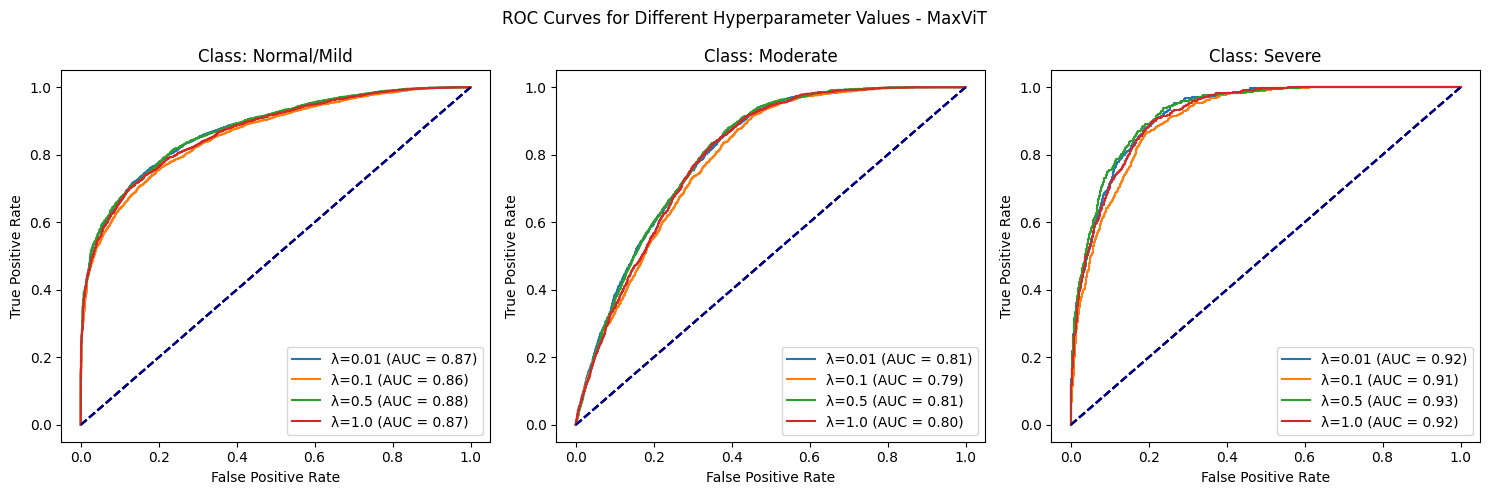

In [14]:
classes = ['Normal/Mild', 'Moderate', 'Severe']
modelName = 'MaxViT'

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle(f'ROC Curves for Different Hyperparameter Values - {modelName}')

# Iterate through each hyperparameter value and compute the ROC curve for each class
for param, y_pred in y_preds_folds.items():
    y_pred_np = y_pred.softmax(1).numpy()
    labels_np = labels_folds[param].numpy()
    for class_idx in range(3):  # Iterate through classes
        # Compute ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(labels_np == class_idx, y_pred_np[:, class_idx])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axs[class_idx].plot(fpr, tpr, label=f"λ={L_values[param]} (AUC = {roc_auc:.2f})")
        axs[class_idx].plot([0, 1], [0, 1], color='navy', linestyle='--')
        axs[class_idx].set_xlabel('False Positive Rate')
        axs[class_idx].set_ylabel('True Positive Rate')
        axs[class_idx].legend(loc='lower right')
        axs[class_idx].set_title(f'Class: {classes[class_idx]}')
        axs[class_idx].grid()

# Display the plot
plt.tight_layout()
plt.savefig('1.eps', format='eps', bbox_inches='tight')
plt.savefig('1.png', bbox_inches='tight')
plt.show()

# ResNet ROC curve

In [15]:
cv = 0
y_preds_folds = {}
labels_folds = {}
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for key in L_values.keys():
    for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
        y_preds = []
        labels = []
        print('#'*30)
        print(f'start fold{fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=1,
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )
    
        model = Classifier(MODEL_NAME_RES_NET) # Change here
        fname = f'{resNetPath}-{key}/{base_model_path}-{fold}.pt' # Change here
        
        model.load_state_dict(torch.load(fname))
        model.to(device)   
        
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        y = model(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
    
        y_preds = torch.cat(y_preds)
        labels = torch.cat(labels)
    
        y_preds_folds[key] = y_preds
        labels_folds[key] = labels
        break

##############################
start fold0
##############################


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

/tmp/ipykernel_23/3680085027.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fname))
100%|██████████| 358/358 [00:26<00:00, 13.51it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:24<00:00, 14.43it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:25<00:00, 14.23it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:24<00:00, 14.40it/s]


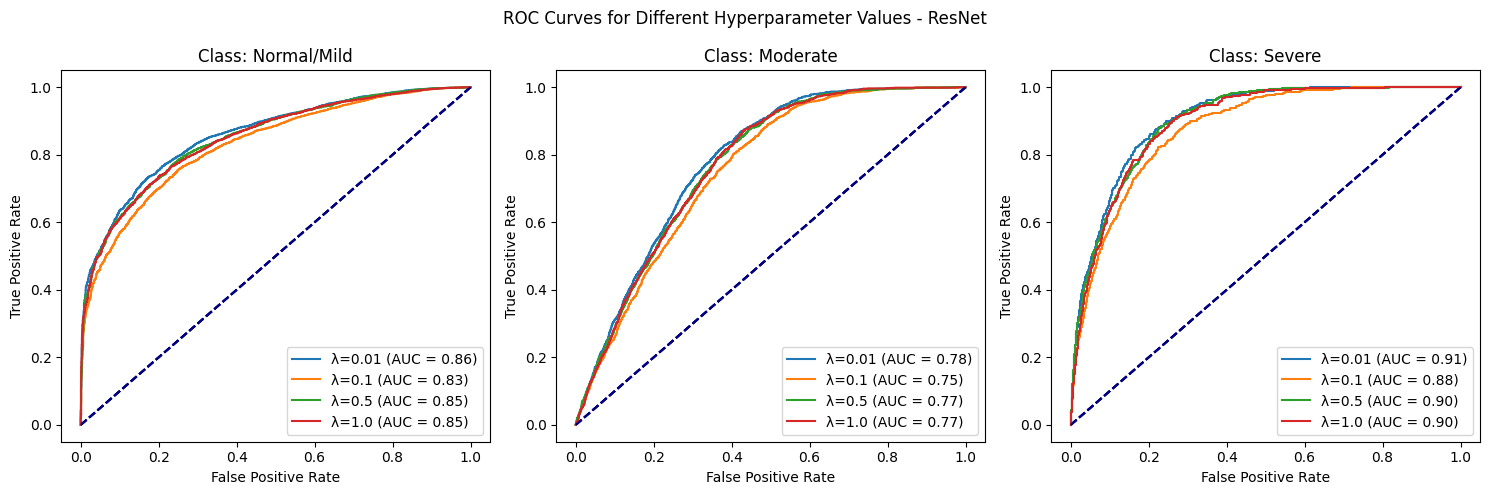

In [16]:
classes = ['Normal/Mild', 'Moderate', 'Severe']
modelName = 'ResNet'

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle(f'ROC Curves for Different Hyperparameter Values - {modelName}')

# Iterate through each hyperparameter value and compute the ROC curve for each class
for param, y_pred in y_preds_folds.items():
    y_pred_np = y_pred.softmax(1).numpy()
    labels_np = labels_folds[param].numpy()
    for class_idx in range(3):  # Iterate through classes
        # Compute ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(labels_np == class_idx, y_pred_np[:, class_idx])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axs[class_idx].plot(fpr, tpr, label=f"λ={L_values[param]} (AUC = {roc_auc:.2f})")
        axs[class_idx].plot([0, 1], [0, 1], color='navy', linestyle='--')
        axs[class_idx].set_xlabel('False Positive Rate')
        axs[class_idx].set_ylabel('True Positive Rate')
        axs[class_idx].legend(loc='lower right')
        axs[class_idx].set_title(f'Class: {classes[class_idx]}')
        axs[class_idx].grid()

# Display the plot
plt.tight_layout()
plt.savefig('2.eps', format='eps', bbox_inches='tight')
plt.savefig('2.png', bbox_inches='tight')
plt.show()

# DenseNet ROC curve

In [17]:
cv = 0
y_preds_folds = {}
labels_folds = {}
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for key in L_values.keys():
    for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
        y_preds = []
        labels = []
        print('#'*30)
        print(f'start fold{fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=1,
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )
    
        model = Classifier(MODEL_NAME_DENSE_NET) # Change here
        fname = f'{denseNetPath}-{key}/{base_model_path}-{fold}.pt' # Change here
        
        model.load_state_dict(torch.load(fname))
        model.to(device)   
        
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        y = model(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
    
        y_preds = torch.cat(y_preds)
        labels = torch.cat(labels)
    
        y_preds_folds[key] = y_preds
        labels_folds[key] = labels
        break

##############################
start fold0
##############################


model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

/tmp/ipykernel_23/2819832751.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fname))
100%|██████████| 358/358 [00:53<00:00,  6.73it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:50<00:00,  7.12it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:50<00:00,  7.10it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:50<00:00,  7.13it/s]


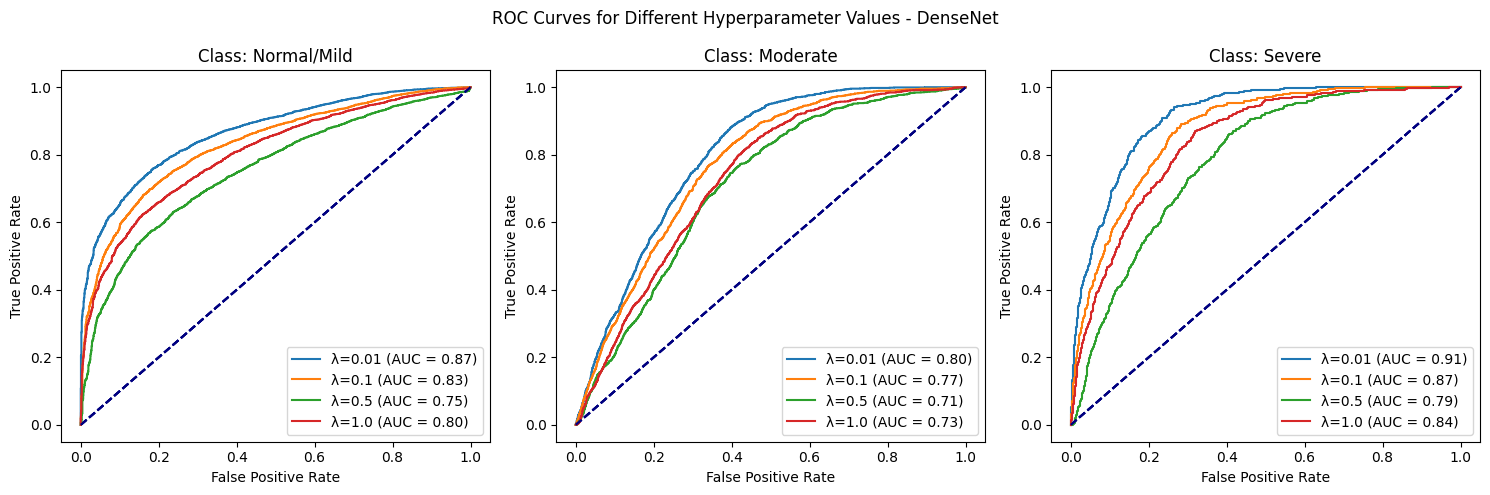

In [18]:
classes = ['Normal/Mild', 'Moderate', 'Severe']
modelName = 'DenseNet'

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle(f'ROC Curves for Different Hyperparameter Values - {modelName}')

# Iterate through each hyperparameter value and compute the ROC curve for each class
for param, y_pred in y_preds_folds.items():
    y_pred_np = y_pred.softmax(1).numpy()
    labels_np = labels_folds[param].numpy()
    for class_idx in range(3):  # Iterate through classes
        # Compute ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(labels_np == class_idx, y_pred_np[:, class_idx])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axs[class_idx].plot(fpr, tpr, label=f"λ={L_values[param]} (AUC = {roc_auc:.2f})")
        axs[class_idx].plot([0, 1], [0, 1], color='navy', linestyle='--')
        axs[class_idx].set_xlabel('False Positive Rate')
        axs[class_idx].set_ylabel('True Positive Rate')
        axs[class_idx].legend(loc='lower right')
        axs[class_idx].set_title(f'Class: {classes[class_idx]}')
        axs[class_idx].grid()

# Display the plot
plt.tight_layout()
plt.savefig('3.eps', format='eps', bbox_inches='tight')
plt.savefig('3.png', bbox_inches='tight')
plt.show()

# EfficientNet ROC curve

In [19]:
cv = 0
y_preds_folds = {}
labels_folds = {}
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for key in L_values.keys():
    for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
        y_preds = []
        labels = []
        print('#'*30)
        print(f'start fold{fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=1,
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )
    
        model = Classifier(MODEL_NAME_EFF_NET) # Change here
        fname = f'{effNetPath}-{key}/{base_model_path}-{fold}.pt' # Change here
        
        model.load_state_dict(torch.load(fname))
        model.to(device)   
        
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        y = model(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
    
        y_preds = torch.cat(y_preds)
        labels = torch.cat(labels)
    
        y_preds_folds[key] = y_preds
        labels_folds[key] = labels
        break

##############################
start fold0
##############################


model.safetensors:   0%|          | 0.00/211M [00:00<?, ?B/s]

/tmp/ipykernel_23/1487036649.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fname))
100%|██████████| 358/358 [00:42<00:00,  8.36it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:42<00:00,  8.44it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:41<00:00,  8.59it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [00:42<00:00,  8.49it/s]


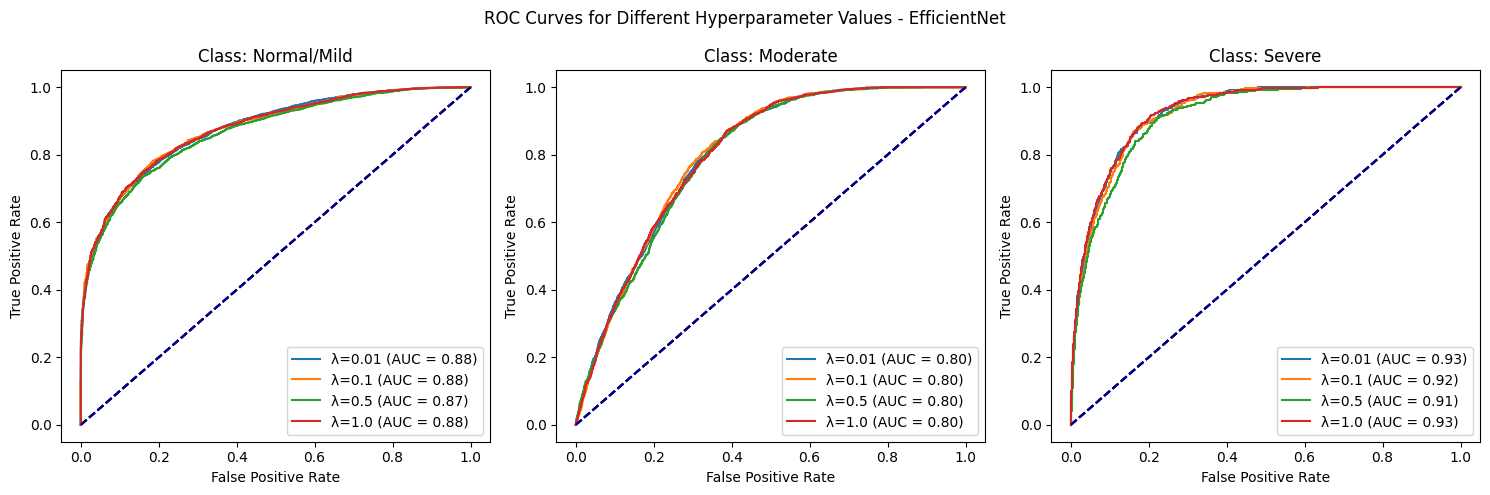

In [20]:
classes = ['Normal/Mild', 'Moderate', 'Severe']
modelName = 'EfficientNet'

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle(f'ROC Curves for Different Hyperparameter Values - {modelName}')

# Iterate through each hyperparameter value and compute the ROC curve for each class
for param, y_pred in y_preds_folds.items():
    y_pred_np = y_pred.softmax(1).numpy()
    labels_np = labels_folds[param].numpy()
    for class_idx in range(3):  # Iterate through classes
        # Compute ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(labels_np == class_idx, y_pred_np[:, class_idx])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axs[class_idx].plot(fpr, tpr, label=f"λ={L_values[param]} (AUC = {roc_auc:.2f})")
        axs[class_idx].plot([0, 1], [0, 1], color='navy', linestyle='--')
        axs[class_idx].set_xlabel('False Positive Rate')
        axs[class_idx].set_ylabel('True Positive Rate')
        axs[class_idx].legend(loc='lower right')
        axs[class_idx].set_title(f'Class: {classes[class_idx]}')
        axs[class_idx].grid()

# Display the plot
plt.tight_layout()
plt.savefig('4.eps', format='eps', bbox_inches='tight')
plt.savefig('4.png', bbox_inches='tight')
plt.show()

# Ensemble Evaluation

In [13]:
cv = 0
y_preds_folds = {}
labels_folds = {}
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
#     fold = 4
    y_preds = []
    labels = []
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    df_valid = df.iloc[val_idx]
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    key_1 = 'l0-1'
    key_2 = 'l1-0'
    key_3 = 'l0-01'
    key_4 = 'l1-0'
    model_1 = Classifier(MODEL_NAME_DENSE_NET) # Change here
    model_2 = Classifier(MODEL_NAME_MAX_VIT)
    model_3 = Classifier(MODEL_NAME_RES_NET)
    model_4 = Classifier(MODEL_NAME_EFF_NET)
    fname_1 = f'{denseNetPath}-{key_1}/{base_model_path}-{fold}.pt' # Change here
    fname_2 = f'{maxVitPath}-{key_2}/{base_model_path}-{fold}.pt'
    fname_3 = f'{resNetPath}-{key_3}/{base_model_path}-{fold}.pt'
    fname_4 = f'{effNetPath}-{key_4}/{base_model_path}-{fold}.pt'
    model_1.load_state_dict(torch.load(fname_1))
    model_1.to(device)
    model_2.load_state_dict(torch.load(fname_2))
    model_2.to(device)
    model_3.load_state_dict(torch.load(fname_3))
    model_3.to(device)
    model_4.load_state_dict(torch.load(fname_4))
    model_4.to(device)
    
    model_1.eval()
    model_2.eval()
    model_3.eval()
    model_4.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):
                
                x = x.to(device)
                t = t.to(device)
                    
                with autocast:
                    y1 = model_1(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                    y2 = model_2(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                    y3 = model_3(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                    y4 = model_4(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])

                    y = (0.05*y1 + 0.4*y2 + 0.15*y3 + 0.4*y4) / 4.0
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col] 
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())
#     break

    y_preds = torch.cat(y_preds)
    labels = torch.cat(labels)

    y_preds_folds[f"fold-{fold}"] = y_preds
    labels_folds[f"fold-{fold}"] = labels

##############################
start fold0
##############################


model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/211M [00:00<?, ?B/s]

/tmp/ipykernel_23/2542615378.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(fname_1))
/tmp/ipykernel_23/2542615378.py:39: FutureWarn

##############################
start fold1
##############################


100%|██████████| 358/358 [02:27<00:00,  2.42it/s]


##############################
start fold2
##############################


100%|██████████| 358/358 [02:28<00:00,  2.41it/s]


##############################
start fold3
##############################


100%|██████████| 358/358 [02:26<00:00,  2.44it/s]


##############################
start fold4
##############################


100%|██████████| 358/358 [02:23<00:00,  2.50it/s]


In [14]:
from sklearn.metrics import classification_report

for fold in range(N_FOLDS):
    print(f"Fold-{fold}\n")
    
    y_preds = y_preds_folds[f"fold-{fold}"]
    labels = labels_folds[f"fold-{fold}"]
    
    y_pred_np = y_preds.softmax(1).numpy()
    labels_np = labels.numpy()
    
    print(classification_report(labels_np, y_pred_np.argmax(1), target_names = ['Normal/Mild', 'Moderate', 'Severe']))
    print('\n')
    print('#'*30)
    print('\n')

Fold-0

              precision    recall  f1-score   support

 Normal/Mild       0.89      0.88      0.89      7004
    Moderate       0.39      0.36      0.38      1402
      Severe       0.42      0.58      0.49       544

    accuracy                           0.78      8950
   macro avg       0.57      0.61      0.58      8950
weighted avg       0.79      0.78      0.78      8950



##############################


Fold-1

              precision    recall  f1-score   support

 Normal/Mild       0.91      0.89      0.90      6984
    Moderate       0.42      0.36      0.39      1427
      Severe       0.39      0.63      0.48       539

    accuracy                           0.79      8950
   macro avg       0.57      0.63      0.59      8950
weighted avg       0.80      0.79      0.79      8950



##############################


Fold-2

              precision    recall  f1-score   support

 Normal/Mild       0.90      0.87      0.88      6865
    Moderate       0.39      0.38  

In [15]:
for fold in range(N_FOLDS):
    print(f"Fold-{fold}\n")
    
    y_preds = y_preds_folds[f"fold-{fold}"]
    labels = labels_folds[f"fold-{fold}"]
    
    y_pred_np = y_preds.softmax(1).numpy()
    labels_np = labels.numpy()
    
    print(f"Weighted log loss: {criterion2(y_preds, labels)}")
    print("Confusion Matrix:")
    print(confusion_matrix(labels_np, y_pred_np.argmax(1)))
    print(f"ROC AUC: {roc_auc_score(labels_np, y_pred_np,multi_class= 'ovo')}")
    print('\n')
    print('#'*30)
    print('\n')

Fold-0

Weighted log loss: 0.8050107955932617
Confusion Matrix:
[[6171  644  189]
 [ 650  511  241]
 [  75  155  314]]
ROC AUC: 0.8273685612516005


##############################


Fold-1

Weighted log loss: 0.8029778003692627
Confusion Matrix:
[[6210  574  200]
 [ 569  520  338]
 [  64  133  342]]
ROC AUC: 0.8242182670406809


##############################


Fold-2

Weighted log loss: 0.8136944770812988
Confusion Matrix:
[[5979  673  213]
 [ 611  554  307]
 [  89  179  345]]
ROC AUC: 0.8143328724960668


##############################


Fold-3

Weighted log loss: 0.8039708733558655
Confusion Matrix:
[[6152  618  184]
 [ 609  534  320]
 [  74  143  316]]
ROC AUC: 0.8216767138499


##############################


Fold-4

Weighted log loss: 0.8106393218040466
Confusion Matrix:
[[6146  665  231]
 [ 598  456  314]
 [  79  159  302]]
ROC AUC: 0.8142092073783358


##############################




# Ensemble ROC curve

In [21]:
cv = 0
y_preds_folds = {}
labels_folds = {}
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for key in L_values.keys():
    for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
        y_preds = []
        labels = []
        print('#'*30)
        print(f'start fold{fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=1,
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )
    
        key_1 = 'l0-1'
        key_2 = 'l1-0'
        key_3 = 'l0-01'
        key_4 = 'l1-0'
        model_1 = Classifier(MODEL_NAME_DENSE_NET) # Change here
        model_2 = Classifier(MODEL_NAME_MAX_VIT)
        model_3 = Classifier(MODEL_NAME_RES_NET)
        model_4 = Classifier(MODEL_NAME_EFF_NET)
        fname_1 = f'{denseNetPath}-{key_1}/{base_model_path}-{fold}.pt' # Change here
        fname_2 = f'{maxVitPath}-{key_2}/{base_model_path}-{fold}.pt'
        fname_3 = f'{resNetPath}-{key_3}/{base_model_path}-{fold}.pt'
        fname_4 = f'{effNetPath}-{key_4}/{base_model_path}-{fold}.pt'
        model_1.load_state_dict(torch.load(fname_1))
        model_1.to(device)
        model_2.load_state_dict(torch.load(fname_2))
        model_2.to(device)
        model_3.load_state_dict(torch.load(fname_3))
        model_3.to(device)
        model_4.load_state_dict(torch.load(fname_4))
        model_4.to(device)
        
        model_1.eval()
        model_2.eval()
        model_3.eval()
        model_4.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        y1 = model_1(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                        y2 = model_2(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                        y3 = model_3(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                        y4 = model_4(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
    
                        y = (0.05*y1 + 0.4*y2 + 0.15*y3 + 0.4*y4) / 4.0
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
    
        y_preds = torch.cat(y_preds)
        labels = torch.cat(labels)
    
        y_preds_folds[key] = y_preds
        labels_folds[key] = labels
        break

##############################
start fold0
##############################


/tmp/ipykernel_23/1000543987.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(fname_1))
/tmp/ipykernel_23/1000543987.py:39: FutureWarn

##############################
start fold0
##############################


100%|██████████| 358/358 [02:00<00:00,  2.97it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [02:01<00:00,  2.95it/s]


##############################
start fold0
##############################


100%|██████████| 358/358 [02:01<00:00,  2.96it/s]


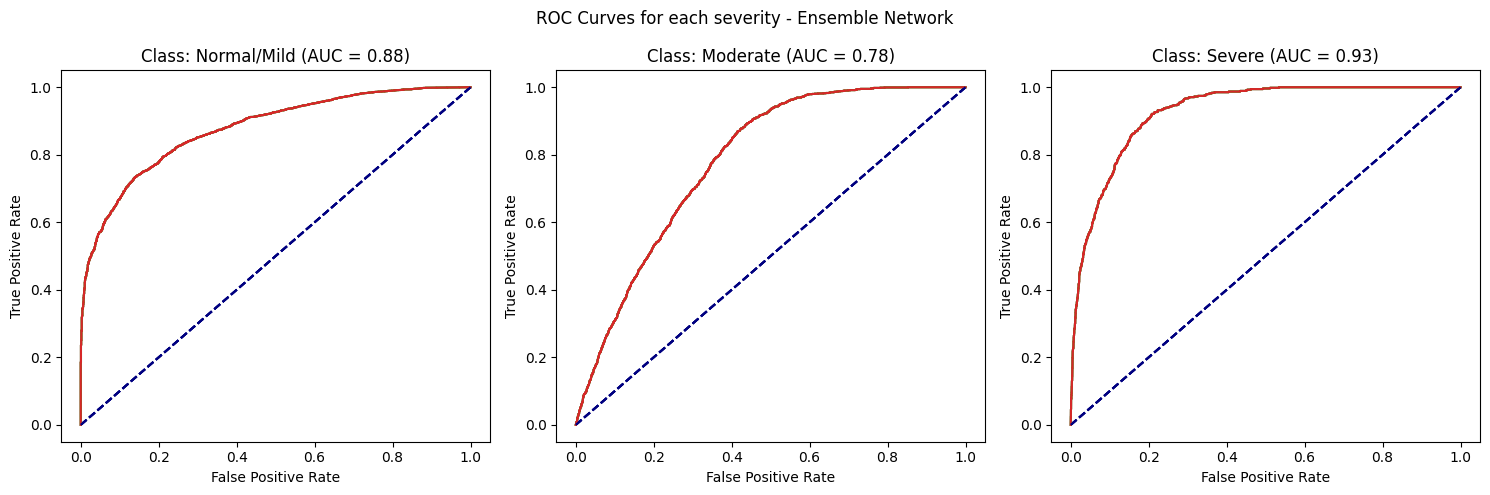

In [26]:
classes = ['Normal/Mild', 'Moderate', 'Severe']
modelName = 'Ensemble'

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle(f'ROC Curves for each severity - {modelName} Network')

# Iterate through each hyperparameter value and compute the ROC curve for each class
for param, y_pred in y_preds_folds.items():
    y_pred_np = y_pred.softmax(1).numpy()
    labels_np = labels_folds[param].numpy()
    for class_idx in range(3):  # Iterate through classes
        # Compute ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(labels_np == class_idx, y_pred_np[:, class_idx])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axs[class_idx].plot(fpr, tpr)
        axs[class_idx].plot([0, 1], [0, 1], color='navy', linestyle='--')
        axs[class_idx].set_xlabel('False Positive Rate')
        axs[class_idx].set_ylabel('True Positive Rate')
        #axs[class_idx].legend(loc='lower right')
        axs[class_idx].set_title(f'Class: {classes[class_idx]} (AUC = {roc_auc:.2f})')
        axs[class_idx].grid()

# Display the plot
plt.tight_layout()
plt.savefig('5.eps', format='eps', bbox_inches='tight')
plt.savefig('5.png', bbox_inches='tight')
plt.show()